# Homework 5 Tasks

## Functions

In [1]:
def computegrad(beta, x, y, lam):
    gradient = 1/len(y) * -(x.T.dot(y*(1/(1+np.exp(y*x.dot(beta)))))) + lam*2*beta
    return np.array(gradient)

def calc_obj(beta, x, y, lam):
    return 1/len(y)*np.sum(np.log(1 + np.exp(-y*x.dot(beta)))) + lam*beta.dot(beta)

def backtracking(beta, x, y, lam, stepSize_init, alpha=0.5, gamma=0.8):
    grad = computegrad(beta, x, y, lam)
    lhs = 1 # for entering while loop
    rhs = 0 # for entering while loop
    t = 0
    stepSize = copy.deepcopy(stepSize_init)
    while lhs > rhs:
        if t == 1:
            stepSize = gamma*stepSize
        else:
            t = 1
        lhs = calc_obj(beta-stepSize*grad, x, y, lam)
        rhs = calc_obj(beta, x, y, lam) - alpha*stepSize*grad.dot(grad)
    return stepSize

def fastgradalgo(beta_init, x, y, lam, stepSize_init, max_iter):
    beta = copy.deepcopy(beta_init)
    theta = copy.deepcopy(beta_init)
    stepCoords = [beta]
    it = 0
    while it < max_iter:
        stepSize = backtracking(beta, x, y, lam, stepSize_init)
        betaNew = theta - stepSize*computegrad(theta, x, y, lam)
        theta = betaNew + (it/(it+3))*(betaNew - beta)
        beta = copy.deepcopy(betaNew)
        stepCoords.append(np.array(beta))
        it += 1
    return np.vstack(stepCoords)

def compute_misclassification_error(beta_opt, x, y):
    y_pred = 1/(1+np.exp(-x.dot(beta_opt))) > 0.5
    y_pred = y_pred*2-1 #Convert to+/−1
    return np.mean(y_pred != y), y_pred

## Data Setup

In [2]:
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
# import data
base_filepath = "/Users/Thompson/Desktop/DATA 558/Final Project/Data/2 - Feature Vectors/"
os.chdir(base_filepath)

train_features = pickle.load(open('1_training_images/att1_raw_images/train_features', 'rb'))
train_labels = pickle.load(open('1_training_images/att1_raw_images/train_labels', 'rb'))
train_labels = np.array(train_labels)

train_features.shape
train_labels.shape

(4320, 2048)

(4320,)

In [4]:
# subset data to two classes of interest (10 = red-winged blackbird; 87 = Mallard)
label_1 = "010"
label_2 = "087"

sub_idxs = np.where(np.logical_or(train_labels == label_1, train_labels == label_2))
labels_text = train_labels[sub_idxs]
features = train_features[sub_idxs]
labels = (labels_text == label_1)*2 - 1
print(labels_text)
print(labels)

['087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '087' '087' '087' '087' '010' '010' '010' '010' '010' '010'
 '010' '010' '010' '010' '010' '010' '010' '010' '010' '010' '010' '010'
 '010' '010' '010' '010' '010' '010' '010' '010' '010' '010' '010' '010']
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1]


In [5]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

# scale and center predictors
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test);

## Bullet 1: $\lambda$ = 1

### Fit Models

my coeffs:
 [ 0.00394027  0.00220006  0.00475733 ..., -0.00585851 -0.00079421
  0.00321153]
sklearn coeffs:
 [ 0.00394036  0.00219999  0.00475714 ..., -0.00585844 -0.00079429
  0.00321152]

     my obj func val:  0.05205687058
sklearn obj func val:  0.052056870569
plot of coefficients:


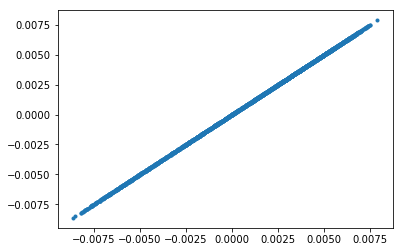

In [6]:
# set initialization parameters
n, p = X_train.shape
lam = 1
stepSize_init = 1 / (scipy.linalg.eigh((1/n)*X_train.T.dot(X_train),
                                       eigvals=(p-1, p-1), eigvals_only=True)[0] + lam)
beta_init = np.zeros(p);

# fit models (mine and sklearn)
my_betas = fastgradalgo(beta_init, X_train, y_train, lam, stepSize_init, 1000)
lr = LogisticRegression(C = 1/(2*lam*n), penalty='l2', fit_intercept=False, tol=10e-8, max_iter=1000)
lr.fit(X_train, y_train);

# coefficients
print("my coeffs:\n", my_betas[-1])
print("sklearn coeffs:\n", lr.coef_[0])

print("\n     my obj func val: ", str(calc_obj(my_betas[-1], X_train, y_train, lam)));
print("sklearn obj func val: ", str(calc_obj(lr.coef_[0], X_train, y_train, lam)));

print("plot of coefficients:")
plt.plot(my_betas[-1], lr.coef_[0], ".");

### Misclassification Error

In [7]:
# test for single beta value first
result_train = compute_misclassification_error(my_betas[-1], X_train, y_train)
result_test = compute_misclassification_error(my_betas[-1], X_test, y_test)
print("training misclassification error = " + str(round(100*result_train[0],1)) + "%")
print("test misclassification error = " + str(round(100*result_test[0],1)) + "%")
print("training predicted:\n", result_train[1])
print("training actual:\n", y_train)
print("test predicted:\n", result_test[1])
print("test actual:\n", y_test)

training misclassification error = 0.0%
test misclassification error = 0.0%
training predicted:
 [ 1  1  1  1  1 -1 -1  1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1
  1 -1  1  1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1  1  1]
training actual:
 [ 1  1  1  1  1 -1 -1  1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1
  1 -1  1  1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1  1  1]
test predicted:
 [-1  1  1 -1 -1 -1  1  1  1 -1 -1 -1]
test actual:
 [-1  1  1 -1 -1 -1  1  1  1 -1 -1 -1]


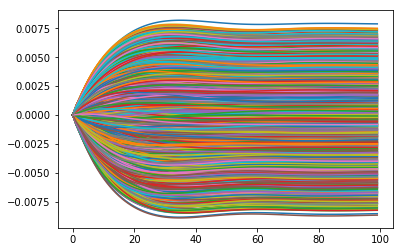

In [8]:
plt.plot(my_betas[0:100]);

In [9]:
# scale up to calculate and save misclassification errors for all beta values
train_error = np.array([])
test_error = np.array([])
for betas in my_betas:
    error = compute_misclassification_error(betas, X_train, y_train)[0]
    train_error = np.append(train_error, error)
    error = compute_misclassification_error(betas, X_test, y_test)[0]
    test_error = np.append(test_error, error)

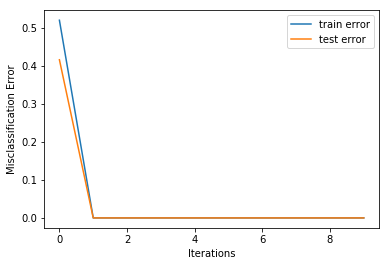

In [10]:
# plot results
plt.plot(train_error[0:10])
plt.plot(test_error[0:10])
plt.legend(["train error", "test error"])
plt.xlabel("Iterations")
plt.ylabel("Misclassification Error");

Amazingly, it seems both training and test error drop to zero after just a single step.

## Bullet 2: $\lambda$ set using cross-validation

In [11]:
# find optimal lambda
lr_cv = LogisticRegressionCV(penalty='l2', fit_intercept=False, tol=10e-8, max_iter=1000)
lr_cv.fit(X_train, y_train)
optimal_lambda = 1/(2*n*lr_cv.C_[0])
print("Optimal lambda =", optimal_lambda);

Optimal lambda = 104.166666667


In [12]:
# fit models (mine and sklearn)
my_betas2 = fastgradalgo(beta_init, X_train, y_train, optimal_lambda, stepSize_init, 1000)
lr2 = LogisticRegression(C=lr_cv.C_[0], penalty='l2', fit_intercept=False, tol=10e-8, max_iter=1000)
lr2.fit(X_train, y_train);

print("my coeffs:\n", my_betas2[-1])
print("sklearn coeffs:\n", lr2.coef_[0])

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=1e-07, verbose=0, warm_start=False)

my coeffs:
 [  6.45019662e-04   4.17827654e-04   9.47876582e-04 ...,  -9.70087435e-04
   3.58336466e-05   6.21979868e-04]
sklearn coeffs:
 [  6.45019661e-04   4.17827654e-04   9.47876582e-04 ...,  -9.70087434e-04
   3.58336483e-05   6.21979870e-04]


In [13]:
# scale up to calculate and save misclassification errors for all beta values
train_error2 = np.array([])
test_error2 = np.array([])
for betas in my_betas2:
    error2 = compute_misclassification_error(betas, X_train, y_train)[0]
    train_error2 = np.append(train_error2, error2)
    error2 = compute_misclassification_error(betas, X_test, y_test)[0]
    test_error2 = np.append(test_error2, error2)

training misclassification error = 0.0%
test misclassification error = 0.0%


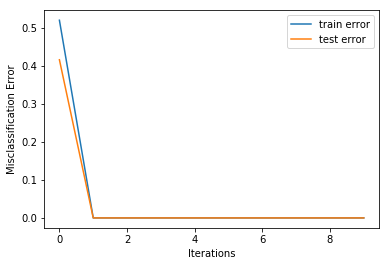

In [14]:
# plot results
plt.plot(train_error[0:10])
plt.plot(test_error[0:10])
plt.legend(["train error", "test error"])
plt.xlabel("Iterations")
plt.ylabel("Misclassification Error");
print("training misclassification error = " + str(round(100*train_error2[-1],1)) + "%")
print("test misclassification error = " + str(round(100*test_error2[-1],1)) + "%");

The change in $\lambda$ apparently has no effect -- the solution again converges after a single iteration.

## OTHER MISC CODE

In [ ]:
def calculate_pair_errors(label_1, label_2):
    
    sub_idxs = np.where(np.logical_or(train_labels == label_1, train_labels == label_2))
    labels_text = train_labels[sub_idxs]
    features = train_features[sub_idxs]
    labels = (labels_text == label_1)*2 - 1

    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

    # scale and center predictors
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # set initialization parameters
    n, p = X_train.shape
    lam = 1
    stepSize_init = 1 / (scipy.linalg.eigh((1/n)*X_train.T.dot(X_train),
                                           eigvals=(p-1, p-1), eigvals_only=True)[0] + lam)
    beta_init = np.zeros(p);
    
    my_betas = fastgradalgo(beta_init, X_train, y_train, lam, stepSize_init, 1000)
    lr = LogisticRegression(C = 1/(2*lam*n), penalty='l2', fit_intercept=False, tol=10e-8, max_iter=1000)
    lr.fit(X_train, y_train);
    
    # plt.plot(my_betas[-1], lr.coef_[0], ".");
    
    print(label_1 + " vs. " + label_2)
    
    result_train = compute_misclassification_error(my_betas[-1], X_train, y_train)
    result_train[1]
    y_train
    print("training misclassification error = " + str(round(100*result_train[0],1)) + "%")

    result_test = compute_misclassification_error(my_betas[-1], X_test, y_test)
    result_test[1]
    y_test
    print("test misclassification error = " + str(round(100*result_test[0],1)) + "%")

In [ ]:
calculate_pair_errors("010", "087")

In [ ]:
list_labels = np.unique(train_labels)
for lab_1 in list_labels[139:]:
    for lab_2 in list_labels[list_labels > lab_1]:
        calculate_pair_errors(lab_1, lab_2)